In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import patsy as ps

from statsmodels.sandbox.regression.gmm import IV2SLS
import os, sys
from dowhy import CausalModel

from IPython.display import Image, display

/home/lawand/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('./csv_data_examples/balke_pearl.csv')
df.head()

,Z,X,Y
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


/home/lawand/dowhy/.venv/lib/python3.10/site-packages/dowhy/causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


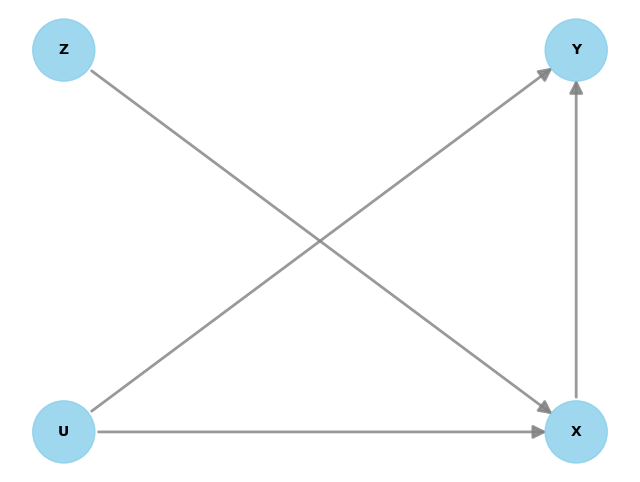

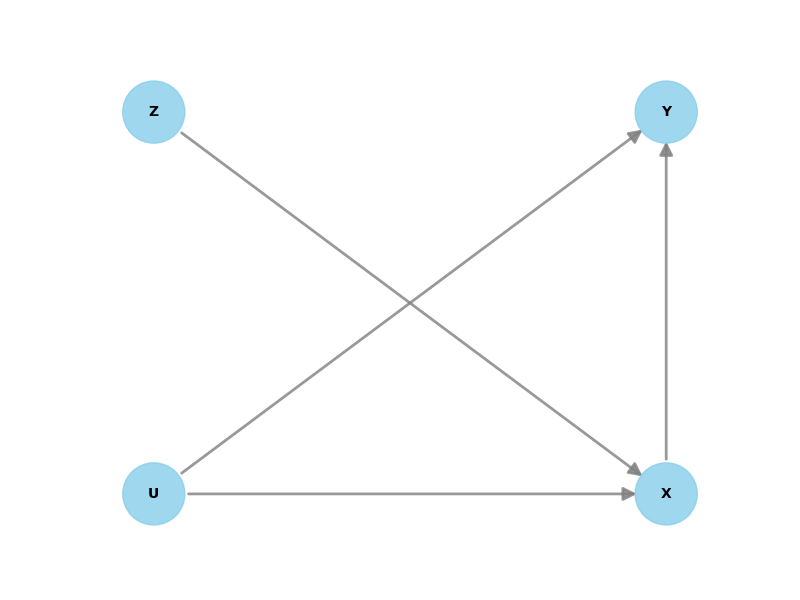

In [32]:
#Step 1: Model

model=CausalModel(
        data = df,
        treatment='X',
        outcome='Y',
        common_causes=['U'],
        instruments=['Z']
        )
model.view_model()

display(Image(filename="causal_model.png"))

In [33]:
# Step 2: Identify
# My notes: identify the causal effect to be estimated based on a causal graph
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([X])⎟  ⎥
 ⎣d[Z]    ⎝d[Z]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{X}, then ¬({Z}→Y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [35]:
# Step 3: Estimate
# Choose the second estimand: using IV
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([X])⎟  ⎥
 ⎣d[Z]    ⎝d[Z]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{X}, then ¬({Z}→Y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡d    ⎤
E⎢──(Y)⎥
 ⎣dZ   ⎦
────────
 ⎡d    ⎤
E⎢──(X)⎥
 ⎣dZ   ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{X}, then ¬({Z}→Y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['X'] is affected in the same way by common causes of ['X'] and ['Y']
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome ['Y'] is affected in the same way by common causes of ['X'] and ['Y']

Targe

In [36]:
# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute") # only permute placebo_type works with IV estimate
print(ref)

Refute: Use a Placebo Treatment
Estimated effect:-1.3636363636363638
New effect:-0.012457912457912466
p value:0.98



In [37]:
income_vec, endog = ps.dmatrices("Y ~ X", data=df)
exog = ps.dmatrix("Z", data=df)

m = IV2SLS(income_vec, endog, exog).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                      Y   R-squared:                      -2.476
Model:                         IV2SLS   Adj. R-squared:                 -2.480
Method:                     Two Stage   F-statistic:                     21.71
                        Least Squares   Prob (F-statistic):           3.60e-06
Date:                Fri, 13 Sep 2024                                         
Time:                        13:06:13                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2327      0.180      6.849      0.000       0.880       1.586
X             -1.3636      0.293     -4.660      0.000      -1.938      -0.789
==============================================================================
Omnibus:                     5627.610   Durbin-Watson:                   0.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.215
Skew:                          -0.140   Prob(JB):                     1.04e-17
Kurtosis:                       1.659   Cond. No.                         2.95
==============================================================================
"""